In [1]:
import xarray as xr
import s3fs
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
from datetime import datetime
import numpy as np
from dask.distributed import Client, LocalCluster
#import netCDF4

In [2]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))

In [7]:
client.close()

In [8]:
remote_files = 's3://escience2022/Antoine/AMSR2_ASI_sea_ice_concentration/asi-AMSR2-n6250-*.nc'
remote_files = s3.glob(remote_files)

In [9]:
# Iterate through remote_files to create a fileset
fileset = [s3.open(file) for file in remote_files]

In [10]:
def paths_to_datetimeindex(paths):
    return  [datetime.strptime(date.split('/')[-1].split('-')[3], '%Y%m%d') for date in paths]

In [11]:
# Create variable used for time axis
time_var = xr.Variable('time', paths_to_datetimeindex(remote_files))
time_var

<xarray.Variable (time: 2733)>
array(['2012-07-02T00:00:00.000000000', '2012-07-03T00:00:00.000000000',
       '2012-07-04T00:00:00.000000000', ...,
       '2019-12-29T00:00:00.000000000', '2019-12-30T00:00:00.000000000',
       '2019-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [12]:
n_workers = 16

In [13]:
cluster = LocalCluster(n_workers = n_workers, memory_limit = "20GB")
client = Client(cluster)

/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40891 instead
  warnings.warn(


In [14]:
# Load in and concatenate all individual .nc files
dset =xr.open_mfdataset(fileset, concat_dim="time", combine = "nested", chunks = {"time":int(len(fileset)/n_workers)}, parallel = True)
dset

2022-11-03 20:18:51,460 - distributed.worker - WARNING - Compute Failed
Key:       open_dataset-42e304e3-998f-4409-b8f4-2b5e6690322f
Function:  execute_task
args:      ((<function apply at 0x7efc1c899670>, <function open_dataset at 0x7efb6aa22790>, [(<class 'tuple'>, [b'\x89HDF\r\n', b'\x1a\n', b'\x02\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\xbb\xf9\r\x00\x00\x00\x00\x000\x00\x00\x00\x00\x00\x00\x00\xba`%\xd2OHDR\x02\r7\x03\x02"\x00\x00\x00\x00\x00\x03\x04\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\n', b"\x02\x00\x01\x00\x00\x00\x00\x10\x10\x00\x00\x00\x00\x7f\x04\x00\x00\x00\x00\x00\x00V\x00\x00\x00\x00\x00\x00\x00\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0c\x8c\x00\x00\x00\x00\x03\x00\x07\x00\x08\x00\x04\x00\x00author\x00\x13\x10\x00\x00p\x00\x00\x00\x02\x00\x00\x00University of Bremen, Gunnar Spreen [gunnar.spreen@uni-bremen.de], Christian Melsheimer [melsheim@

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'cfgrib', 'pydap', 'rasterio', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

/docs.xarray.dev/en/stable/getting-started-guide/installing.html\\nhttps://docs.xarray.dev/en/stable/user-guide/io.html")'

2022-11-03 20:18:54,691 - distributed.worker - WARNING - Compute Failed
Key:       open_dataset-b0d9dce5-f003-4754-9625-2b413bcebcce
Function:  execute_task
args:      ((<function apply at 0x7fe0fce29670>, <function open_dataset at 0x7fe05d594820>, [(<class 'tuple'>, [b'\x89HDF\r\n', b'\x1a\n', b'\x02\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\xac\xc9\x13\x00\x00\x00\x00\x000\x00\x00\x00\x00\x00\x00\x00\n', b'B\xcbyOHDR\x02\r7\x03\x02"\x00\x00\x00\x00\x00\x03\x04\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\n', b"\x02\x00\x01\x00\x00\x00\x00\x10\x10\x00\x00\x00\x00\x7f\x04\x00\x00\x00\x00\x00\x00V\x00\x00\x00\x00\x00\x00\x00\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0c\x8c\x00\x00\x00\x00\x03\x00\x07\x00\x08\x00\x04\x00\x00author\x00\x13\x10\x00\x

In [ ]:
dset = dset.assign_coords(time=time_var)
dset.to_netcdf('AMSR2_ASI_sea_ice_concentration.nc')

task
args:      ((<function apply at 0x7f868f08f670>, <function open_dataset at 0x7f85dd267dc0>, [(<class 'tuple'>, [b'\x89HDF\r\n', b'\x1a\n', b'\x02\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x98\xc2\x11\x00\x00\x00\x00\x000\x00\x00\x00\x00\x00\x00\x00$\xf0\xb9zOHDR\x02\r7\x03\x02"\x00\x00\x00\x00\x00\x03\x04\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\n', b"\x02\x00\x01\x00\x00\x00\x00\x10\x10\x00\x00\x00\x00\x7f\x04\x00\x00\x00\x00\x00\x00V\x00\x00\x00\x00\x00\x00\x00\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0c\x8c\x00\x00\x00\x00\x03\x00\x07\x00\x08\x00\x04\x00\x00author\x00\x13\x10\x00\x00p\x00\x00\x00\x02\x00\x00\x00University of Bremen, Gunnar Spreen [gunnar.spreen@uni-bremen.de], Christian Melsheimer [melsheim@uni-bremen.de]\x0c'\x00\x00\x01\x00\x03\x00\x0c\x00\x08\x00\x04\x00\x00Conventions\x00\x13\x10\x00\x00\x06\x00\x00\x00\x02\x00\x00\x00CF-1.5\x0c=\x00\

In [11]:
ds_month = dset.groupby('time.month').mean(keep_attrs=True)
ds_month

<xarray.Dataset>
Dimensions:  (month: 6, y: 1792, x: 1216)
Coordinates:
  * x        (x) float64 -3.847e+06 -3.841e+06 ... 3.741e+06 3.747e+06
  * y        (y) float64 -5.347e+06 -5.341e+06 ... 5.841e+06 5.847e+06
  * month    (month) int64 7 8 9 10 11 12
Data variables:
    z        (month, y, x) float32 dask.array<chunksize=(1, 1792, 1216), meta=np.ndarray>
Attributes:
    author:       University of Bremen, Gunnar Spreen [gunnar.spreen@uni-brem...
    Conventions:  CF-1.5
    GMT_version:  5.2.1 (r15220) [64-bit] [MP]
    history:      Mon Jan 21 18:50:27 2019: GDAL CreateCopy( /ssmi/www/htdocs...
    info:         AMSR2 sea ice concentration based on the ASI algorithm (Spr...
    title:        Produced by grdmath
    GDAL:         GDAL 2.1.3, released 2017/20/01

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


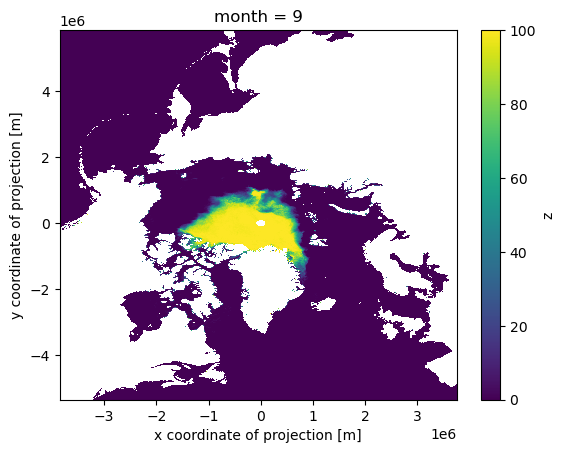

In [13]:
ds_month.z.sel(month = 9).plot()

In [14]:
area = 6.25**2
ice = ds_month.z.sel(month = 9)
ice_m = ice.where(ice >= 15)
var = ice_m/ice_m

In [15]:
area*var.sum().values

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


3671875.0